In [1]:
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
import optuna
from joblib import Parallel, delayed
from utils.Loader import NEUDataset
from utils.Perspectiver import Perspectiver
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import multiprocessing
import torch
from mpl_toolkits.mplot3d import Axes3D
from skimage.restoration import denoise_wavelet
import random
import math

/home/lingfeng/Desktop/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class GaussianFilter(torch.nn.Module):
    def __init__(self, kernel_size: int, sigma: float):
        super(GaussianFilter, self).__init__()
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.kernel = self._create_gaussian_kernel(kernel_size, sigma)
    
    def _create_gaussian_kernel(self, kernel_size: int, sigma: float):
        """Creates a 2D Gaussian kernel."""
        x = torch.arange(kernel_size) - kernel_size // 2
        y = torch.arange(kernel_size) - kernel_size // 2
        xx, yy = torch.meshgrid(x, y, indexing='ij')
        kernel = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))
        kernel = kernel / kernel.sum()
        return kernel
    
    def forward(self, x):
        """Applies the Gaussian filter to an input tensor."""
        if x.ndim == 2:  # Add batch and channel dimensions if missing
            x = x.unsqueeze(0).unsqueeze(0)  # Shape [1, 1, H, W]
        
        kernel = self.kernel.to(x.device).unsqueeze(0).unsqueeze(0)  # Shape [1, 1, K, K]
        x = F.conv2d(x, kernel, padding=self.kernel_size // 2)
        return x.squeeze(0).squeeze(0)

In [3]:
dataset = NEUDataset(set="train", transform=None, seed=1, scale=0.5)

# Probar con un DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Intentar iterar sobre el dataloader
for images, labels in dataloader:
    print("Iteración exitosa.")
    print("Imagen shape:", images.shape)
    print("Etiqueta shape:", labels.shape)
    break 

Iteración exitosa.
Imagen shape: torch.Size([4, 1, 100, 100])
Etiqueta shape: torch.Size([4, 6])


In [4]:
image, label = dataset.__getitem__(index=random.randint(2, len(dataset)))
original_image = Perspectiver.grayscale_to_rgb(Perspectiver.normalize_to_uint8(image.detach().cpu().numpy()[0]))

In [5]:
def optimize_image(image, n_tries: int = 100):
    """
    Optimizes the mean shift parameters to maximize the metric: (Silhouette Score / Number of Clusters).

    Args:
        image (np.array): The input image with shape (200, 200, 3).
        n_tries (int): The number of optimization trials to run.

    Returns:
        dict: The best parameters and the best score.
    """

    # Define the objective function for Optuna
    def objective(trial):
        # Suggest parameters for spatial radius and color radius
        sp = trial.suggest_float("sp", 1.0, 60.0)  # Spatial window radius
        sr = trial.suggest_float("sr", 1.0, 60.0)  # Color window radius

        # Apply mean shift filtering
        after = Perspectiver.meanShift(image, sp, sr)

        # Evaluate clustering
        scores = Perspectiver.evaluate_clustering(image, after)
        score = scores["Davies-Bouldin Index"]
        n_clusters = len(np.unique(after))

        # Avoid division by zero (in case of degenerate clustering)
        if n_clusters == 0:
            return float("-inf")

        # Metric to maximize: Silhouette Score per cluster
        metric_to_maximize = math.log2(score)*n_clusters
        return metric_to_maximize

    # Determine the number of CPU threads
    n_jobs = multiprocessing.cpu_count()-2
    print(f"Using {n_jobs} CPU threads for parallel optimization.")

    # Run the optimization with parallel trials
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_tries, n_jobs=n_jobs)

    # Return the best parameters and the best score
    return {
        "best_params": study.best_params,
        "best_score": study.best_value
    }


In [6]:
def plot_barchartImage(image):
    x = np.arange(image.shape[0])
    y = np.arange(image.shape[1])
    x, y = np.meshgrid(x, y)

    # Flatten arrays for plotting
    x = x.flatten()
    y = y.flatten()
    z = np.zeros_like(x)
    dx = dy = np.ones_like(x)
    dz = image.flatten()

    # Plot the 3D bar chart
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.bar3d(x, y, z, dx, dy, dz, shade=True)

    # Add labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Value')
    ax.set_title('3D Bar Chart of (200, 200) Array')

    plt.show()

In [7]:
BEST = optimize_image(original_image, n_tries=200)["best_params"]
BEST

[I 2025-01-29 14:29:17,777] A new study created in memory with name: no-name-d2761376-a5c8-4402-a4b3-bc2df8dfc064


Using 6 CPU threads for parallel optimization.


[I 2025-01-29 14:29:21,906] Trial 5 finished with value: 710.2847209568218 and parameters: {'sp': 16.473956742636986, 'sr': 46.79870216024778}. Best is trial 5 with value: 710.2847209568218.
[I 2025-01-29 14:29:22,421] Trial 3 finished with value: 569.8110793092601 and parameters: {'sp': 22.01654584262967, 'sr': 43.59387043695766}. Best is trial 5 with value: 710.2847209568218.
[I 2025-01-29 14:29:22,632] Trial 4 finished with value: 1082.1315428191533 and parameters: {'sp': 32.69699756619337, 'sr': 55.36959171235966}. Best is trial 4 with value: 1082.1315428191533.
[I 2025-01-29 14:29:22,769] Trial 1 finished with value: 68.23116259174725 and parameters: {'sp': 59.37125044150793, 'sr': 56.526452737455905}. Best is trial 4 with value: 1082.1315428191533.
[I 2025-01-29 14:29:23,399] Trial 2 finished with value: 795.1834743337688 and parameters: {'sp': 32.80212314873481, 'sr': 29.466234385942652}. Best is trial 4 with value: 1082.1315428191533.
[I 2025-01-29 14:29:24,201] Trial 0 finishe

{'sp': 1.3370234994426937, 'sr': 37.34599094428859}

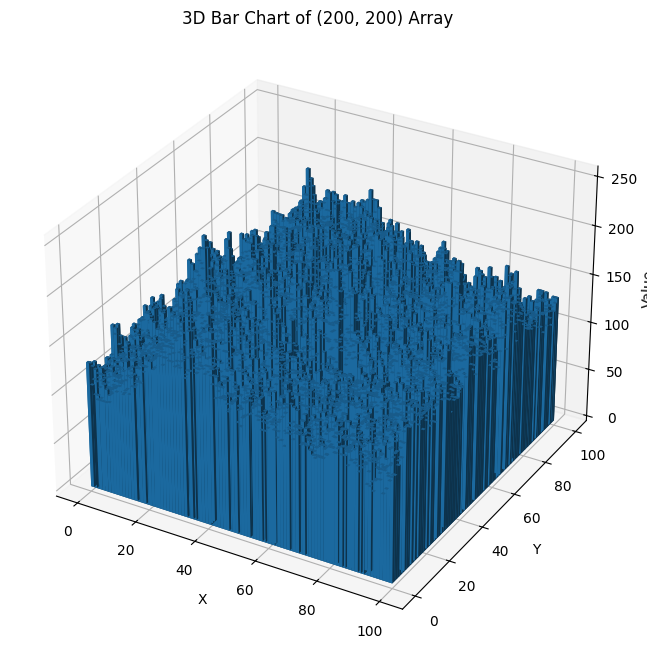

In [8]:
plot_barchartImage(Perspectiver.rgb_to_grayscale(original_image))

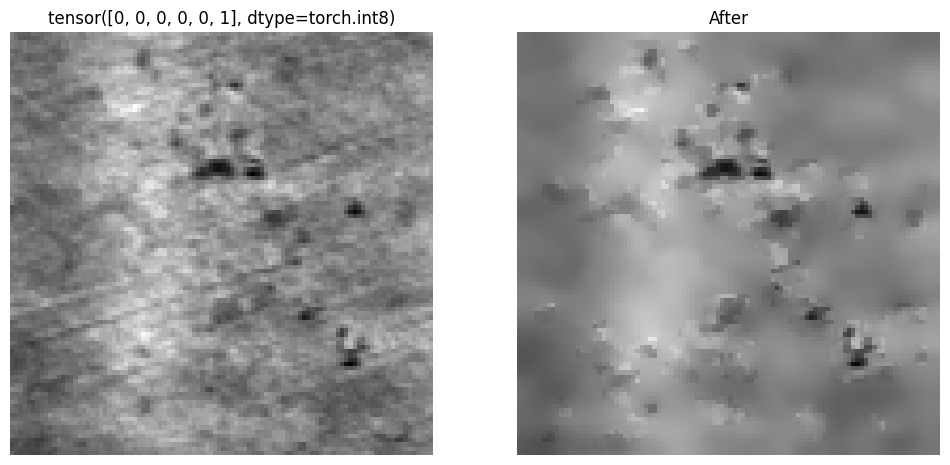

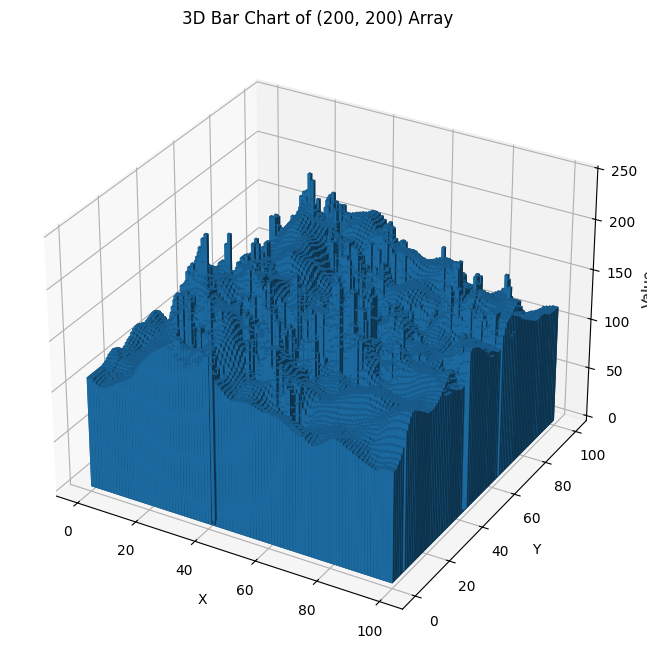

{'Silhouette Score': np.float64(-0.3307373628260974),
 'Davies-Bouldin Index': np.float64(83646.8248956832),
 'Calinski-Harabasz Index': np.float64(371.4102934205812),
 'Silhouette Score/n': np.float64(-0.001797485667533138),
 'Davies-Bouldin Index/n': np.float64(454.60230921566955),
 'Calinski-Harabasz Index/n': np.float64(2.018534203372724)}

In [9]:
clustered_image = Perspectiver.meanShift(original_image, BEST["sp"], BEST["sr"])
Perspectiver.plotComparison(original_image, clustered_image, titleBefore=label)
plot_barchartImage(Perspectiver.rgb_to_grayscale(clustered_image))
Perspectiver.evaluate_clustering(original_image, clustered_image)

In [15]:
def nl_means_opencv(image: np.ndarray, h: int = 10, template_window_size: int = 7, search_window_size: int = 21):
    """
    Aplica filtro Non-Local Means usando la implementación de OpenCV (CPU).

    Args:
        image (np.ndarray): Imagen de entrada (BGR).
        h (int): Fuerza de filtrado (mayor -> filtrado más fuerte).
        template_window_size (int): Tamaño del parche usado en comparación.
        search_window_size (int): Tamaño del área para buscar parches similares.
    Returns:
        np.ndarray: Imagen filtrada.
    """
    if not isinstance(image, np.ndarray):
        raise TypeError("La imagen debe ser un arreglo NumPy.")
    # fastNlMeansDenoisingColored trabaja en BGR y retorna BGR
    filtered = cv2.fastNlMeansDenoisingColored(
        src=image,
        h=h,
        hColor=h,
        templateWindowSize=template_window_size,
        searchWindowSize=search_window_size
    )
    return filtered

def optimize_NL_Filter(image, n_tries: int = 100):

    # Define the objective function for Optuna
    def objective(trial):
        # Suggest parameters for spatial radius and color radius
        h = trial.suggest_int("h", 0, 255)  # Spatial window radius
        tws = trial.suggest_int("template_window_size", 1.0, 60.0)  # Color window radius
        sws = trial.suggest_int("search_window_size", 1.0, 60.0)  # Color window radius

        # Apply mean shift filtering
        after = nl_means_opencv(image, h, tws, sws)

        # Evaluate clustering
        scores = Perspectiver.evaluate_clustering(image, after)
        score = scores["Davies-Bouldin Index"]
        n_clusters = len(np.unique(after))

        # Avoid division by zero (in case of degenerate clustering)
        if n_clusters == 0:
            return float("-inf")

        # Metric to maximize: Silhouette Score per cluster
        metric_to_maximize = math.log2(score)*n_clusters
        return metric_to_maximize

    # Determine the number of CPU threads
    n_jobs = multiprocessing.cpu_count()-2
    print(f"Using {n_jobs} CPU threads for parallel optimization.")

    # Run the optimization with parallel trials
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_tries, n_jobs=n_jobs)

    # Return the best parameters and the best score
    return {
        "best_params": study.best_params,
        "best_score": study.best_value
    }

In [17]:
BEST = optimize_NL_Filter(original_image, n_tries=200)["best_params"]
BEST

[I 2025-01-29 14:40:23,420] A new study created in memory with name: no-name-32fa47f0-2eaa-4260-af03-40fde287b1e9


Using 6 CPU threads for parallel optimization.


[I 2025-01-29 14:40:26,802] Trial 3 finished with value: 401.125932601402 and parameters: {'h': 67, 'template_window_size': 30, 'search_window_size': 14}. Best is trial 3 with value: 401.125932601402.
[I 2025-01-29 14:40:26,920] Trial 5 finished with value: 425.4176192325465 and parameters: {'h': 245, 'template_window_size': 29, 'search_window_size': 15}. Best is trial 5 with value: 425.4176192325465.
[I 2025-01-29 14:40:27,325] Trial 0 finished with value: 394.67788211161354 and parameters: {'h': 106, 'template_window_size': 56, 'search_window_size': 18}. Best is trial 5 with value: 425.4176192325465.
[I 2025-01-29 14:40:27,692] Trial 4 finished with value: 248.54737331931997 and parameters: {'h': 170, 'template_window_size': 43, 'search_window_size': 34}. Best is trial 5 with value: 425.4176192325465.
[I 2025-01-29 14:40:28,472] Trial 2 finished with value: 118.42136849600777 and parameters: {'h': 128, 'template_window_size': 34, 'search_window_size': 58}. Best is trial 5 with value:

{'h': 67, 'template_window_size': 15, 'search_window_size': 5}

In [18]:
clustered_image = nl_means_opencv(original_image, h= BEST["h"], template_window_size=BEST["template_window_size"], search_window_size=BEST["search_window_size"])
Perspectiver.plotComparison(original_image, clustered_image, titleBefore=label)
plot_barchartImage(Perspectiver.rgb_to_grayscale(clustered_image))
Perspectiver.evaluate_clustering(original_image, clustered_image)

TypeError: optimize_NL_Filter() got an unexpected keyword argument 'h'